# Greedily construct the neural population that explains the most MTN variance

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from disp import set_plot

from record import smlt_ppln_ma
from my_torch import skl_fit_lin_single, skl_fit_ridge_add_col

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'
PFX_NRL = f'data/simple/mlv/ma_red_greedy/nrl/ma_red_greedy_nrl'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

## Define complete neural population

In [5]:
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

n = len(tau_rs)
r_cols = [f'R_{cr}' for cr in range(n)]

## Simulate population recordings

## Iteratively and greedily add next best neuron to MTN predictor set

In [ ]:
N_MAX = 50

nrns_greedy = {targ: [] for targ in TARGS}

r2_train_greedy = {targ: [] for targ in TARGS}
r2_test_greedy = {targ: [] for targ in TARGS}

for citer in range(N_MAX):
    
    if citer == 0:
        rslt = skl_fit_lin_single(
            pfxs=[PFX_NRL, PFX_BHV],
            cols_x=r_cols,
            targs=TARGS,
            itr_all=ISTRAIN,
            ntrain=NTRAIN,
            nsplit=NSPLIT,
            verbose=False)
        
    else:
        cols_x_fixed = {
            targ: [f'R_{inrn}' for inrn in nrns_greedy[targ]]
            for targ in TARGS
        }
        
        rslt = skl_fit_ridge_add_col(
            pfxs=[PFX_NRL, PFX_BHV],
            cols_x=r_cols,
            cols_x_fixed=cols_x_fixed,
            targs=TARGS,
            itr_all=ISTRAIN,
            ntrain=NTRAIN,
            nsplit=NSPLIT,
            alpha=ALPHA,
            verbose=False)
        
    for targ in TARGS:
        r2_train_mn = rslt.r2_train[targ].mean(axis=0)  # avg over splits
        r2_test_mn = rslt.r2_test[targ].mean(axis=0)
        
        nrns_greedy[targ].append(np.argmax(r2_test_mn))
        
        r2_train_greedy[targ].append(np.max(r2_train_mn))
        r2_test_greedy[targ].append(np.max(r2_test_mn))
        
    # save results
    np.save(f'data/simple/mlv/ma_red_greedy/ma_red_greedy_max_{N_MAX}.npy', np.array([
        {'nrns_greedy': nrns_greedy, 'r2_train_greedy': r2_train_greedy, 'r2_test_greedy': r2_test_greedy}
    ]))


Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Loading...
Splits:XXXXXXXXXXXXXXXXXXX

## Plot variance explained vs # neurons for each target

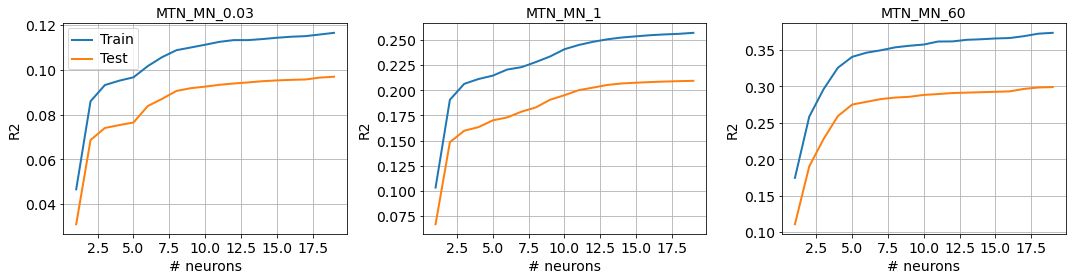

In [6]:
load_data = np.load('data/simple/mlv/ma_red_greedy/ma_red_greedy_max_50.npy', allow_pickle=True)[0]

r2_train_greedy = load_data['r2_train_greedy']
r2_test_greedy = load_data['r2_test_greedy']

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.plot(1 + np.arange(len(r2_train_greedy[targ])), r2_train_greedy[targ], lw=2)
    ax.plot(1 + np.arange(len(r2_test_greedy[targ])), r2_test_greedy[targ], lw=2)
    if ax is axs[0]:
        ax.legend(['Train', 'Test'])
    set_plot(ax, x_label='# neurons', y_label='R2', title=targ, font_size=14)
    
    ax.grid()

In [7]:
# print out time constants of neurons
nrns_greedy = load_data['nrns_greedy']
for targ in TARGS:
    print('')
    print(targ)
    for cnrn, nrn in enumerate(nrns_greedy[targ]):
        r2 = r2_test_greedy[targ][cnrn]
        print(f'Neuron {cnrn+1} (R2 = {r2:.5f}): {nrn}: TAU_R = {tau_rs[nrn]:.1f}, TAU_A = {tau_as[nrn]:.1f}, X_S = {x_ss[nrn]:.2f}, X_P = {x_ps[nrn]:.2f}')


MTN_MN_0.03
Neuron 1 (R2 = 0.03101): 236: TAU_R = 120.0, TAU_A = 30.0, X_S = 1.00, X_P = 0.00
Neuron 2 (R2 = 0.06866): 135: TAU_R = 10.0, TAU_A = 0.1, X_S = 0.00, X_P = 1.00
Neuron 3 (R2 = 0.07404): 242: TAU_R = 120.0, TAU_A = inf, X_S = 1.00, X_P = 0.00
Neuron 4 (R2 = 0.07533): 16: TAU_R = 0.1, TAU_A = 10.0, X_S = 0.50, X_P = 0.50
Neuron 5 (R2 = 0.07651): 183: TAU_R = 30.0, TAU_A = 60.0, X_S = 0.00, X_P = 1.00
Neuron 6 (R2 = 0.08386): 165: TAU_R = 30.0, TAU_A = 0.5, X_S = 0.00, X_P = 1.00
Neuron 7 (R2 = 0.08708): 159: TAU_R = 10.0, TAU_A = inf, X_S = 0.00, X_P = 1.00
Neuron 8 (R2 = 0.09061): 197: TAU_R = 60.0, TAU_A = 1.0, X_S = 1.00, X_P = 0.00
Neuron 9 (R2 = 0.09184): 162: TAU_R = 30.0, TAU_A = 0.1, X_S = 0.00, X_P = 1.00
Neuron 10 (R2 = 0.09254): 137: TAU_R = 10.0, TAU_A = 0.1, X_S = 1.00, X_P = 0.00
Neuron 11 (R2 = 0.09335): 25: TAU_R = 0.1, TAU_A = inf, X_S = 0.50, X_P = 0.50
Neuron 12 (R2 = 0.09394): 177: TAU_R = 30.0, TAU_A = 10.0, X_S = 0.00, X_P = 1.00
Neuron 13 (R2 = 0.0944